In [ ]:
# %%

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import ttest_1samp, ttest_ind
from scipy.stats import pearsonr

from dieboldmariano import dm_test

from sklearn.metrics import r2_score
from sklearn.metrics import cohen_kappa_score


def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [ ]:
# %%

tick = "1d"

df_bars = pd.read_csv(
    f"../data/ohlc_{tick}_gateio.csv", index_col=0, parse_dates=True)
df_close = df_bars.filter(axis="columns", like="close")
df_close.columns = [x.split("_")[0] for x in df_close.columns]

tick = "24h"
df_close = df_close.resample(tick).last()

In [ ]:
# %%

n_train_days = 120
df_ica_pred = pd.read_csv(
    f"../data/ica_arma_predictions_{tick}_{n_train_days}D.csv",
    index_col=0,
    parse_dates=True)

df_arima_pred = pd.read_csv(
    f"../data/arma_predictions_{tick}_{n_train_days}D.csv",
    index_col=0,
    parse_dates=True)

df_pca_pred = pd.read_csv(
    f"../data/pca_arma_predictions_{tick}_{n_train_days}D.csv",
    index_col=0,
    parse_dates=True)#.shift(-1).dropna()

df_ret = df_close.pct_change().fillna(0).loc[df_pca_pred.index, df_pca_pred.columns].unstack()

df_pca_pred = df_pca_pred.iloc[:-1].unstack()
df_ica_pred = df_ica_pred.iloc[1:].unstack()
df_arima_pred = df_arima_pred.unstack()

df_ret = df_ret.reindex(df_ica_pred.index)

# scale ica preds with scalar
df_ica_pred *= df_pca_pred.var() / df_ica_pred.var()

In [ ]:
#%%

#naive_forecast = df_ret.reset_index().sample(frac=1.0, replace=True)[0].to_frame().set_index(df_ret.index)[0]
naive_forecast = df_ret.shift().fillna(0)

# %% [markdown]

  # Empirical Results

# %% [markdown]

 ## Directional accuracy
 - Diebold Mariano test shows **Directional Accuarcy** (correct sign of returns predicted) for ica_arima significantly **better** than pca + arima

In [ ]:
#%%

print("Diebold Mariano test statistic, p-value:",
dm_test(
    np.sign(df_ret).values,
    np.sign(df_ica_pred).values,
    np.sign(df_pca_pred).values,
    loss=lambda a, b: abs(a - b),
    one_sided=True))

Diebold Mariano test statistic, p-value: (np.float64(-1.5766232830513518), np.float64(0.05745326445920368))


In [ ]:
#%%

# Convert continuous predictions to directional predictions (+1 for positive, -1 for negative)
actual_direction = np.sign(df_ret).values
ica_direction = np.sign(df_ica_pred).values
pca_direction = np.sign(df_pca_pred).values
naive_direction = np.sign(naive_forecast).values

# Calculate Cohen's Kappa for all models
ica_kappa = cohen_kappa_score(actual_direction, ica_direction)
pca_kappa = cohen_kappa_score(actual_direction, pca_direction)
naive_kappa = cohen_kappa_score(actual_direction, naive_direction)

print(f"Cohen's Kappa - ICA ARIMA: {ica_kappa:.4f}")
print(f"Cohen's Kappa - PCA ARIMA: {pca_kappa:.4f}")
print(f"Cohen's Kappa - Naive Forecast: {naive_kappa:.4f}")

Cohen's Kappa - ICA ARIMA: 0.0402
Cohen's Kappa - PCA ARIMA: 0.0231
Cohen's Kappa - Naive Forecast: -0.0976


In [ ]:
#%%

ica_directional_error = np.abs(np.sign(df_ret).values - np.sign(df_ica_pred).values).sum() / (2 * len(df_ret))
print(f"ICA ARIMA Directional Error: {ica_directional_error:.4f}")

pca_directional_error = np.abs(np.sign(df_ret).values - np.sign(df_pca_pred).values).sum() / (2 * len(df_ret))
print(f"PCA ARIMA Directional Error: {pca_directional_error:.4f}")

naive_directional_error = np.abs(np.sign(df_ret).values - np.sign(naive_forecast).values).sum() / (2 * len(df_ret))
print(f"Naive Forecast Directional Error: {naive_directional_error:.4f}")

ICA ARIMA Directional Error: 0.4781
PCA ARIMA Directional Error: 0.4883
Naive Forecast Directional Error: 0.5484


# %% [markdown]

  ## $R^2$ (Explained Variance)
 - **Explained Variance** of ica_arima **better** than just pca + arima

In [ ]:
#%%

print(f"R² Score - ICA ARIMA: {r2_score(df_ret, df_ica_pred):.4f}")
print(f"R² Score - PCA ARIMA: {r2_score(df_ret, df_pca_pred):.4f}")
print(f"R² Score - Naive Forecast: {r2_score(df_ret, naive_forecast):.4f}")

R² Score - ICA ARIMA: -0.0027
R² Score - PCA ARIMA: -0.0389
R² Score - Naive Forecast: -1.0746


# %% [markdown]

  ## R (Pearson Correlation)
 - **Pearson Correlation** of ica_arima **worse** than pca + arima

In [ ]:
# %%

ica_corr, ica_p = pearsonr(df_ret, df_ica_pred, alternative="greater")
pca_corr, pca_p = pearsonr(df_ret, df_pca_pred, alternative="greater")
naive_corr, naive_p = pearsonr(df_ret, naive_forecast, alternative="greater")

print(f"Pearson Correlation - ICA ARIMA: {ica_corr:.4f} (p-value: {ica_p:.4f})")
print(f"Pearson Correlation - PCA ARIMA: {pca_corr:.4f} (p-value: {pca_p:.4f})")
print(f"Pearson Correlation - Naive Forecast: {naive_corr:.4f} (p-value: {naive_p:.4f})")

Pearson Correlation - ICA ARIMA: 0.0129 (p-value: 0.0711)
Pearson Correlation - PCA ARIMA: 0.0297 (p-value: 0.0003)
Pearson Correlation - Naive Forecast: -0.0373 (p-value: 1.0000)


# %% [markdown]

 ## Mean Absolute Error
 - Diebold Mariano test shows **Mean Absolute Error** of ica_arima predicitons significantly **better** than pca + arima

In [ ]:
#%%

print("Diebold Mariano test statistic, p-value:",
dm_test(
    df_ret.values,
    df_ica_pred.values,
    df_pca_pred.values,
    loss=lambda a, b: abs(a - b),
    one_sided=True))

Diebold Mariano test statistic, p-value: (np.float64(-9.9677416003629), np.float64(1.2786319782669299e-23))


In [ ]:
#%%

ica_mae_error = np.abs(df_ret.values - df_ica_pred.values).sum() / len(df_ret)
print(f"ICA ARIMA MAE: {round(float(ica_mae_error), 4)}")

pca_mae_error = np.abs(df_ret.values - df_pca_pred.values).sum() / len(df_ret)
print(f"PCA ARIMA MAE: {round(float(pca_mae_error), 4)}")

naive_mae_error = np.abs(df_ret.values - naive_forecast.values).sum() / len(df_ret)
print(f"Naive Forecast MAE: {round(float(naive_mae_error), 4)}")

ICA ARIMA MAE: 0.0338
PCA ARIMA MAE: 0.035
Naive Forecast MAE: 0.0517


# %% [markdown]

 ## Mean Squared Error
 - Diebold Mariano test shows **Mean Squared Error** of ica_arima predicitons significantly **better** than pca + arima

In [ ]:
#%%

print("Diebold Mariano test statistic, p-value:",
dm_test(
    df_ret.values,
    df_ica_pred.values,
    df_pca_pred.values,
    loss=lambda a, b: (a - b)**2,
    one_sided=True))

Diebold Mariano test statistic, p-value: (np.float64(-3.7971724258081725), np.float64(7.351027632845069e-05))


In [ ]:
#%%

ica_mse_error = ((df_ret.values - df_ica_pred.values)**2).sum() / len(df_ret)
print(f"ICA ARIMA MSE: {round(float(ica_mse_error), 4)}")

pca_mse_error = ((df_ret.values - df_pca_pred.values)**2).sum() / len(df_ret)
print(f"PCA ARIMA MSE: {round(float(pca_mse_error), 4)}")

naive_mse_error = ((df_ret.values - naive_forecast.values)**2).sum() / len(df_ret)
print(f"Naive Forecast MSE: {round(float(naive_mse_error), 4)}")

ICA ARIMA MSE: 0.0039
PCA ARIMA MSE: 0.0041
Naive Forecast MSE: 0.0081


# %% [markdown]

 ## Comaparison of ARIMA orders
 - for just ARIMA the AutoARIMA algorithm determined Brownian Noise with order (0, 1, 0) to be the best model of the process
 way more often than for ica + ARIMA, indicating application of ICA improved the Signal to Noise Ratio

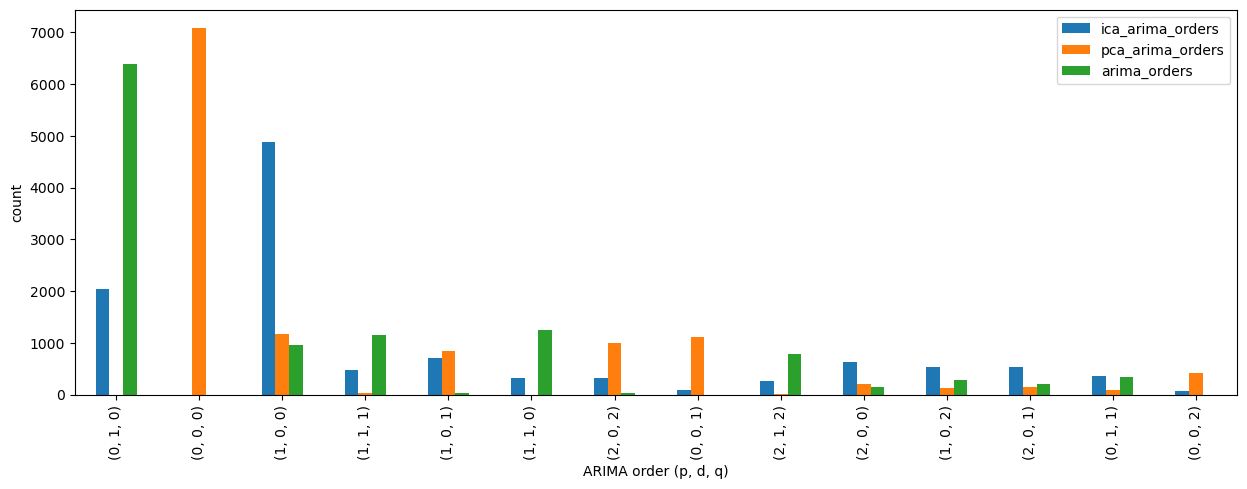

In [ ]:
#%%

n_train_days = 120
tick = "24h"
ica_orders = pd.read_csv(f"../data/ica_arma_orders_{tick}_{n_train_days}D.csv", index_col=0)
pca_arima_orders = pd.read_csv(f"../data/pca_arma_orders_{tick}_{n_train_days}D.csv", index_col=0)
arima_orders = pd.read_csv(f"../data/arma_orders_{tick}_{n_train_days}D.csv", index_col=0)
orders = pd.concat((
    ica_orders.unstack().value_counts().rename("ica_arima_orders"),
    pca_arima_orders.unstack().value_counts().rename("pca_arima_orders"),
    arima_orders.unstack().value_counts().rename("arima_orders")
    ), axis=1, join="outer")

orders.iloc[np.argsort(orders.sum(axis=1))[:-15:-1]].plot.bar(figsize=(15, 5))
#orders.iloc[np.argsort(orders["arima_orders"].values)[:-30:-1]].plot.bar(figsize=(15, 5))
#orders.iloc[np.argsort(orders.sum(axis=1))[::-1]].plot.bar(figsize=(15, 5))
plt.xlabel("ARIMA order (p, d, q)")
plt.ylabel("count")
plt.show();